# M6 Time Domain Metric Analysis

The M6 metric examines how often a survey region is revisited.  All science cases, by definition, require at least one visit to all HEALpixels in their desired survey region, while some indicate that multiple visits would be needed. The M6 metric calculates the area of a desired survey region to actually receive the requested number of visits in a survey strategy and compares this with the requested cadence. The result is expressed as a percentage of the requested visits, M6_%sky_area_nvisits.

Unlike the other metrics, this calculation is made separately for each region within a (science case, filter) or (survey design, filter) combination. This is because some cases request different cadence strategies for different sub-regions.

As a result, the metric output is quite complicated, and its best evaluated in smaller segments.

In [1]:
from os import path, getcwd
from sys import path as pythonpath
pythonpath.append(path.join(getcwd(), '..'))
from astropy.table import Table, Column, vstack
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import config_utils
import regions
import plot_metric_results
import visualization_utils
import numpy as np
from astropy import units as u 
from mw_plot import MWSkyMap

## Setup

In [2]:
sim_config = config_utils.read_config(path.join(getcwd(), '..', 'config', 'sim_config.json'))

In [3]:
science_cases = config_utils.read_config(path.join(getcwd(), '..', 'config', 'rgps_science_cases.json'))

science_categories = []
for author, info in science_cases.items():
    if info['ready_for_use'] and info['category'] not in science_categories:
        science_categories.append(info['category'])
science_categories

['wide_area',
 'time_domain',
 'SFR',
 'solar_system',
 'high_cadence',
 'globular_clusters',
 'molecular_clouds',
 'AGN',
 'open_clusters',
 'variable_stars',
 'galactic_center',
 'keyholes',
 'stellar_spectra',
 'extinction',
 'novae',
 'ISM',
 'YSO',
 'GW']

In [4]:
# Calculate the number of time domain proposals 
time_domain_cases = {author: info for author, info in science_cases.items() if (info['ready_for_use'] and info['time_domain'])}
print('Identified ' + str(len(time_domain_cases)) + ' time domain science case')
print(', '.join(time_domain_cases.keys()))

Identified 14 time domain science case
Paladini2, Benecchi, Kupfer, Lian, DAmmando, Freeman, Navarro, Morihana2, Morihana1, Daylan, Bahramian, Rich2, Bonito, Pardo


## Configuration of time domain proposals 

In the JSON format files in config/ time domain parameters are included for each requested observing region independently, to enable different regions to receive different observing strategies.  The parameters are:

In [5]:
nvisits= 8 # floating point - nvisits < 1.0 indicates that multiple filters will be used within a single visit
duration= 3.5  # [days] Interval between the first and last observation of the current region
visit_interval= '[0.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]' # [hours, can be null] Intervals between successive visits

## M6 Sky area revisits - Time domain metric 

There are many comparisions which can be made for this metric (in terms of science regions, survey regions, filters and survey elements), since each region can have a different observing strategy in terms of number of visits, filter choice etc.  This makes it quite complicated to compare the metric in a uniform way for all science cases simultaneously. 

Given the RGPS survey as designed, only the time_domain fields provide meaningful time domain coverage, so we focus here on the results of evaluating the M6 metric for RGPS time domain fields, comparing them to the regions requested in community proposals categorize as time domain.  

Note: In this metric table, the metric is calculated for each survey region and science region and filter.  However, in some cases 
there may be no survey observations of any region in the given filter, so no specific regions are specified and the name of the survey - i.e. "time_domain" as a whole is listed for the region.  

### Time domain region overlap

Cumulatively, the community requested time domain observations of a very large area of sky, far more than the RGPS' time allocation could possibly support.  So the first question to address is which regions - and therefore which science cases - were included in the design.  This metric considers observations in any filter, on the grounds that several authors indicated that observations in any of a set of filters would be beneficial.  

This information is in the first of the two tables of output produced by M6. 

In [7]:
# Load the M6 metric results for the high cadence field observations
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_nvisits_combined_overlap_results.txt')

m6_results1 = Table.read(m6_results_file, format='ascii')
m6_results1.pprint_all()

          Survey_region                   Science_region           Common_area         M6_%TD_Region   
---------------------------------- --------------------------- -------------------- -------------------
time_domain_TDS_Galactic_Center_Q4            Freeman_RRLyrae1   1.5736755847709376  10.135135135135135
time_domain_TDS_Galactic_Center_Q1            Freeman_RRLyrae1   1.5736755847709376  10.135135135135135
      time_domain_TDS_NGC6334_6357            Freeman_RRLyrae1                  0.0                 0.0
            time_domain_TDS_Carina            Freeman_RRLyrae1                  0.0                 0.0
               time_domain_TDS_W43            Freeman_RRLyrae1                  0.0                 0.0
       time_domain_TDS_Serpens_W40            Freeman_RRLyrae1                  0.0                 0.0
time_domain_TDS_Galactic_Center_Q4            Freeman_RRLyrae2                  0.0                 0.0
time_domain_TDS_Galactic_Center_Q1            Freeman_RRLyrae2  

Let's tabulate which regions were included and which not.  Note that there is a special case made for catalog which include a large number of target areas.  Including these regions separately doesn't make much sense and overwhelms the table, so the metric sums the region of overlap for all survey regions over all targets in the catalog before calculating the metric. 

In [8]:
# Build a list of the regions from all science cases 
science_regions = list(set(m6_results1['Science_region']))
science_regions.sort()

# Build a list of the survey time domain regions
survey_regions = list(set(m6_results1['Survey_region']))
survey_regions.sort()

In [9]:
# For each science region, check to see which if any survey region overlaps with it, tabulating the results 
data = []
for rscience in science_regions:
    print(rscience)
    
    # Filter for the results for this region
    idx = np.where(m6_results1['Science_region'] == rscience)[0]
    metric_filter = m6_results1[idx]

    # Identify which region overlaps if any 
    jdx = np.where(metric_filter['Common_area'] > 0.0)[0]

    # Desired region not covered by survey fields
    if len(jdx) == 0: 
        data.append([rscience, 'Any', 0.0, 0.0])

    # Desired region covered by one or more fields 
    else:
        for j in jdx: 
            data.append(
                [
                    rscience, 
                    metric_filter[j]['Survey_region'].replace('time_domain_',''), 
                    metric_filter[j]['Common_area'], 
                    metric_filter[j]['M6_%TD_Region']
                ]
            )
    
data = np.array(data)

overlap_results = Table([
        Column(name='Science_region', data=data[:, 0], dtype='S40'),
        Column(name='Survey_region', data=data[:, 1], dtype='S50'),
        Column(name='Common_area', data=data[:, 2], dtype='f8'),
        Column(name='M6_%TD_Region', data=data[:, 3], dtype='f8'),
    ])

overlap_results.pprint_all()

Bahramian_XRB1
Bahramian_XRB2
Benecchi_Benecchi1
Bonito_Carina
Bonito_NGC 2264
Bonito_NGC 6530
Bonito_NGC 6611
Bonito_Orion Nebula Cluster
DAmmando_DAmmando_catalog
Daylan_Berkeley53
Daylan_King7
Daylan_NGC2099
Daylan_NGC2158
Daylan_NGC869
Freeman_RRLyrae1
Freeman_RRLyrae2
Freeman_RRLyrae3
Freeman_RRLyrae4
Kupfer_NGC6522
Kupfer_NGC6528
Kupfer_UKS1
Kupfer_VVV_CL001
Lian_Carina
Morihana1_Subaru1
Morihana1_Subaru2
Morihana2_CVs1
Morihana2_CVs2
Navarro_ulens1
Paladini2_Paladini2
Pardo_-90deg
Pardo_90deg
Rich2_Rich_TDA1
Rich2_Rich_TDA2
       Science_region           Survey_region          Common_area         M6_%TD_Region   
--------------------------- ---------------------- -------------------- -------------------
             Bahramian_XRB1 TDS_Galactic_Center_Q4    3.986644814753042 0.08964484129324478
             Bahramian_XRB1 TDS_Galactic_Center_Q1   3.9341889619273442 0.08846530390780735
             Bahramian_XRB1       TDS_NGC6334_6357    3.566997992147459 0.08020854220974534
   

The second stage of the M6 metric evaluates how suitable the time cadence of observing strategy is for each science case. 

In [10]:
# Load the M6 metric results for the high cadence field observations
m6_results_file = path.join(getcwd(), '..', 'metric_results', 'M6_sky_area_nvisits_combined_results.txt')

m6_results2 = Table.read(m6_results_file, format='ascii')
m6_results2

Survey_strategy,Survey_region,Science_case,Science_region,Optic,M6_%nvisits,M6_%duration
str11,str34,str9,str27,str4,float64,float64
wide_area,wide_area,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
deep_spec,deep_spec,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Galactic_Center_Q4,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Galactic_Center_Q1,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_NGC6334_6357,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Carina,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
time_domain,time_domain_TDS_Serpens_W40,Paladini2,Paladini2_Paladini2,F213,100.0,83.42857142857143
time_domain,time_domain_TDS_W43,Paladini2,Paladini2_Paladini2,F213,0.0,0.0
wide_area,wide_area,Navarro,Navarro_ulens1,F106,0.0,0.0


We'd like to know which of the requested regions receives the desired coverage.  The discrete nature of the time domain fields means that it only makes sense to consider the survey fields that overlap the requested region.  However, several science cases asked for a huge catalog of fields, while others asked for all filters and a large set of fields.  Plotting all of these on a single plot is complicated, so opting for more specific graphics here.  

In [11]:
# For each combination of science and survey region with known overlap, extract the metric data for each filter 
# requested by the science case.  
# Plot M6_%nvisits vs M6_%duration for each science/survey region overlap
data = []
for row in overlap_results:
    
    # Select metric table entries for all filters requested for the row's science region
    rscience = row['Science_region']
    rsurvey = row['Survey_region']
    idx1 = np.where(m6_results2['Science_region'] == rscience)[0]
    idx2 = np.where(m6_results2['Survey_region'] == 'time_domain_' + rsurvey)[0]
    idx = list(set(idx1).intersection(set(idx2)))

    for i in idx:
        data.append([rscience, rsurvey, m6_results2[i]['Optic'], m6_results2[i]['M6_%nvisits'], m6_results2[i]['M6_%duration']])

data = np.array(data)

metric_results = Table([
        Column(name='Science_region', data=data[:, 0], dtype='S40'),
        Column(name='Survey_region', data=data[:, 1], dtype='S50'),
        Column(name='Optic', data=data[:,2], dtype='S30'),
        Column(name='M6_%nvisits', data=data[:, 3], dtype='f8'),
        Column(name='M6_%duration', data=data[:, 4], dtype='f8'),
    ])

metric_results.pprint_all()

   Science_region       Survey_region      Optic     M6_%nvisits         M6_%duration    
------------------- ---------------------- ----- ------------------- --------------------
     Bahramian_XRB1 TDS_Galactic_Center_Q4  F129   11.11111111111111    67.77777777777779
     Bahramian_XRB1 TDS_Galactic_Center_Q4  F087 0.12222222222222222  0.37222222222222223
     Bahramian_XRB1 TDS_Galactic_Center_Q4  F213   66.66666666666666                 70.0
     Bahramian_XRB1 TDS_Galactic_Center_Q1  F129   11.11111111111111    67.77777777777779
     Bahramian_XRB1 TDS_Galactic_Center_Q1  F087 0.12222222222222222  0.37222222222222223
     Bahramian_XRB1 TDS_Galactic_Center_Q1  F213   66.66666666666666                 70.0
     Bahramian_XRB1       TDS_NGC6334_6357  F213   47.77777777777778   0.3888888888888889
     Bahramian_XRB1       TDS_NGC6334_6357  F129 0.12222222222222222   0.4444444444444444
     Bahramian_XRB1       TDS_NGC6334_6357  F087 0.12222222222222222   0.4444444444444444
     Bahra

Science_region Survey_region Optic     M6_%nvisits     M6_%duration
-------------- ------------- ----- ------------------- ------------
 Bonito_Carina    TDS_Carina  F062 0.11458333333333333         40.0
Science_region Survey_region Optic     M6_%nvisits     M6_%duration
-------------- ------------- ----- ------------------- ------------
 Bonito_Carina    TDS_Carina  F129 0.11458333333333333         40.0
Science_region     Survey_region      Optic    M6_%nvisits         M6_%duration    
-------------- ---------------------- ----- ------------------ --------------------
Navarro_ulens1 TDS_Galactic_Center_Q4  F106 0.9166666666666666 0.045890410958904115
Science_region     Survey_region      Optic    M6_%nvisits       M6_%duration  
-------------- ---------------------- ----- ----------------- -----------------
Navarro_ulens1 TDS_Galactic_Center_Q4  F129 83.33333333333334 8.356164383561644
Science_region     Survey_region      Optic M6_%nvisits   M6_%duration  
-------------- ------------

/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_50745/4047127485.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, fontsize=18)
/var/folders/1d/5hlyfsgd0kl_nd815xmp9cv00000gn/T/ipykernel_50745/4047127485.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=18)


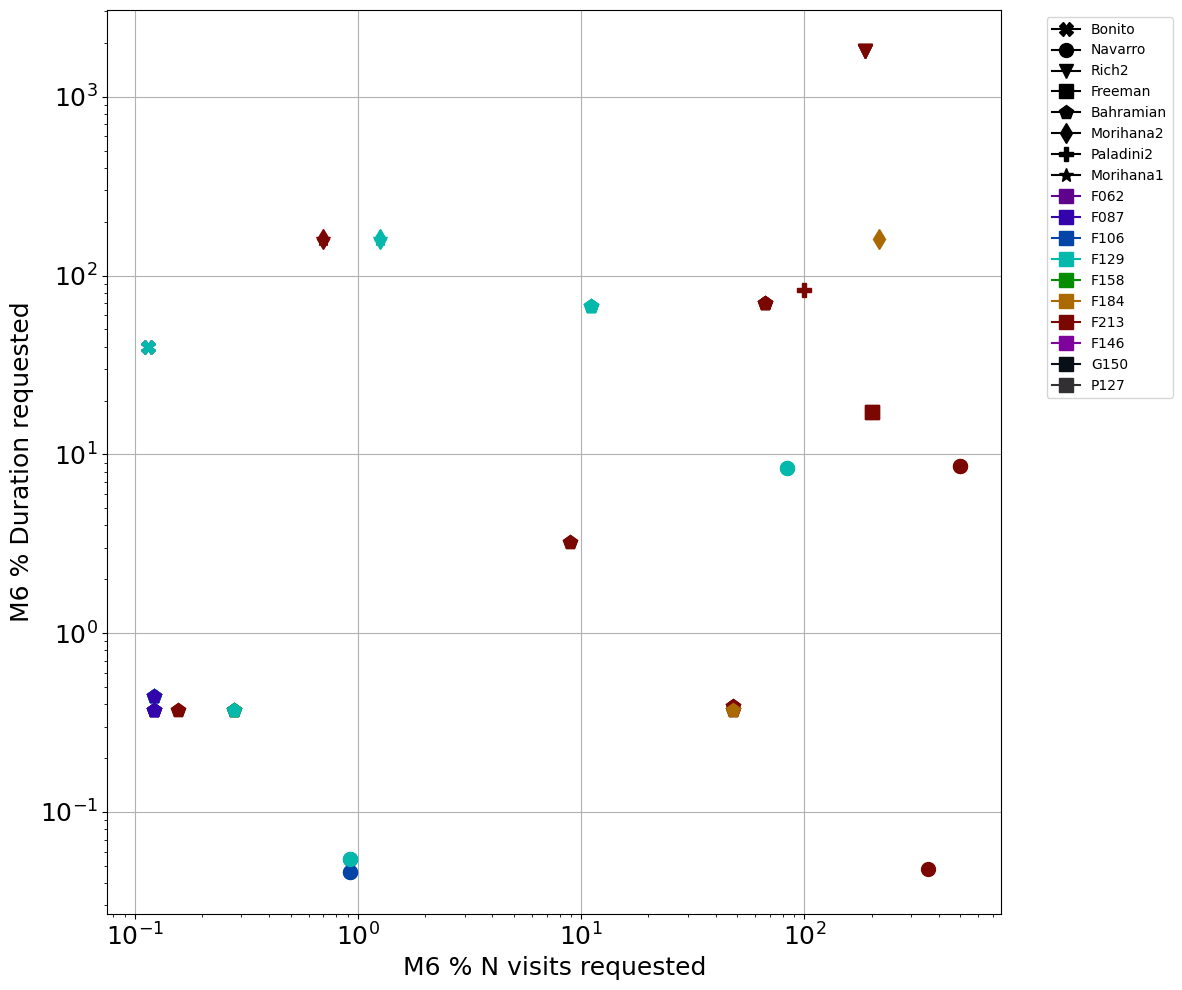

In [13]:
authors = [x.split('_')[0] for x in metric_results['Science_region']]
authors = list(set(authors))
plot_symbols = ["X",  "o",  "v", "s", "p", "d", "P", "*", "<", ">"]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10))

for i,author in enumerate(authors):
    rows = [entry for entry in metric_results if author in entry['Science_region']]
    
    for entry in rows:
        print(entry)
        ax.plot(
            entry['M6_%nvisits'], 
            entry['M6_%duration'], 
            marker=plot_symbols[i], 
            color=sim_config['PLOT_COLORS'][entry['Optic']],
            markersize=10.0
        )

    # Create invisible data for each author to generate a legend
    ax.plot(0.0, 0.0, marker=plot_symbols[i], 
            color='black', alpha=0.0, label=author)

# Add invisible data to represent the filter colors
for optic in sim_config['OPTICAL_COMPONENTS']:
    ax.plot(0.0, 0.0,
        marker='s', markersize=10,
        color=sim_config['PLOT_COLORS'][optic],
            alpha=0.0, label=optic)
    
ax.loglog()
legend1 = ax.legend(bbox_to_anchor=(1.2, 1))
for lh in legend1.legend_handles: 
    lh.set_alpha(1)
    lh.set_markersize(10.0)

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, fontsize=18)
ax.set_xlabel('M6 % N visits requested', fontsize=18)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)
ax.set_ylabel('M6 % Duration requested', fontsize=18)
ax.grid()

plt.tight_layout()
plt.savefig(path.join(sim_config['root_dir'], 'metric_results', 'm6_results_nvisits_duration.png'))

Note that not all time domain proposals are represented in the above plot.  This is because we have not plotted any requested region which does not lie within the time domain fields and/or does not receive observations in the filters requested. 

It is possible for data in this plot to have metric percentages higher than 100% - this indicates that a field received either more visits than a science case asked for, or that observations continued over a longer duration than specified. 

In interpreting this plot, it should be remembered that the survey cadence is considered for each filter.  For example, Bahramian requested observations of two large regions for X-ray binary studies, but asked for observations in F087, F129, F146, F158, F184 and F213. While the total time required would be beyond the scope of the RGPS, time series observations are included in F213 for some smaller regions of overlap.  Single exposures will be acquired in F062, F087, F106 and F129.  

Feedback from the community has indicated a degree of flexibility in many science cases regarding the filter choice(s), so preference was given to achieving good temporal coverage in one, frequently-requested passband rather than several.  